# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [21]:
import os
import keras
from keras.models import model_from_json


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [22]:
train, test = keras.datasets.cifar10.load_data()

In [23]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [24]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [25]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [26]:
## 超參數設定
"""
Set your required experiment parameters
"""
OPTIMIZERS = ['Adam','SGD', 'RMSprop'] #, 'AdaGrad']
LEARNING_RATE = [0.1, 1e-2, 1e-4]
EPOCHS =50
BATCH_SIZE = 128
MOMENTUM = [0.95]
NETSTEROV = True

In [27]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 3072), (10000, 3072), (50000, 10), (10000, 10))

In [28]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""   
for method in OPTIMIZERS:
    for lr in LEARNING_RATE:
        for mmt in MOMENTUM:
            keras.backend.clear_session() # 把舊的 Graph 清掉

            #print("Experiment with LR = %.8f" % (lr))
            exp_name_tag = "exp-{}-lr-{}-mmt-{}".format(str(method),str(lr),str(mmt))
            print(">>> ", str(exp_name_tag))

            model = build_mlp(input_shape=x_train.shape[1:])
            model.summary()
            
            if method == 'RMSprop':
                optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=1e-5, decay=1e-6)
            elif method == 'SGD':
                optimizer = keras.optimizers.SGD(lr=lr, nesterov=NETSTEROV, momentum=mmt)
            else:# method == 'Adma':
                optimizer = keras.optimizers.Adam(lr=lr, epsilon=1e-5, decay=1e-6)
            
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

>>>  exp-Adam-lr-0.1-mmt-0.95
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 29s 590us/step - loss: 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 27s 545us/step - loss: 1.8685 - acc: 0.3346 - val_loss: 1.7555 - val_acc: 0.3811
Epoch 2/50
50000/50000 [==============================] - 27s 532us/step - loss: 1.6816 - acc: 0.4058 - val_loss: 1.6444 - val_acc: 0.4187
Epoch 3/50
50000/50000 [==============================] - 27s 534us/step - loss: 1.6034 - acc: 0.4331 - val_loss: 1.5715 - val_acc: 0.4437
Epoch 4/50
50000/50000 [==============================] - 27s 533us/step - loss: 1.5398 - acc: 0.4569 - val_loss: 1.5286 - val_acc: 0.4620
Epoch 5/50
50000/50000 [==============================] - 27s 534us/step - loss: 1.4977 - acc: 0.4697 - val_loss: 1.4923 - val_acc: 0.4697
Epoch 6/50
50000/50000 [==============================] - 27s 536us/step - loss: 1.4546 - acc: 0.4862 - val_loss: 1.5048 - val_acc: 0.4581
Epoch 7/50
50000/50000 [==============================] - 27s 534us/step - loss: 1.4227 - acc: 0.4987 - val_loss: 1.

50000/50000 [==============================] - 18s 364us/step - loss: 2.1516 - acc: 0.1749 - val_loss: 1.9888 - val_acc: 0.2320
Epoch 2/50
50000/50000 [==============================] - 18s 360us/step - loss: 2.0677 - acc: 0.2063 - val_loss: 2.1629 - val_acc: 0.1665
Epoch 3/50
50000/50000 [==============================] - 18s 358us/step - loss: 2.2127 - acc: 0.1522 - val_loss: 2.3038 - val_acc: 0.1001
Epoch 4/50
50000/50000 [==============================] - 18s 359us/step - loss: 2.2330 - acc: 0.1369 - val_loss: 2.3020 - val_acc: 0.0991
Epoch 5/50
50000/50000 [==============================] - 18s 359us/step - loss: 2.2106 - acc: 0.1385 - val_loss: 2.3059 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 18s 358us/step - loss: 2.3058 - acc: 0.1016 - val_loss: 2.3068 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 18s 357us/step - loss: 2.3055 - acc: 0.1009 - val_loss: 2.3060 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.5867 - acc: 0.4343 - val_loss: 1.5475 - val_acc: 0.4478
Epoch 3/50
50000/50000 [==============================] - 18s 363us/step - loss: 1.5099 - acc: 0.4588 - val_loss: 1.4998 - val_acc: 0.4607
Epoch 4/50
50000/50000 [==============================] - 18s 363us/step - loss: 1.4548 - acc: 0.4810 - val_loss: 1.5507 - val_acc: 0.4568
Epoch 5/50
50000/50000 [==============================] - 18s 364us/step - loss: 1.4036 - acc: 0.5020 - val_loss: 1.4247 - val_acc: 0.4926
Epoch 6/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.3671 - acc: 0.5144 - val_loss: 1.3898 - val_acc: 0.5069
Epoch 7/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.3384 - acc: 0.5225 - val_loss: 1.3854 - val_acc: 0.5130
Epoch 8/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.2991 - acc: 0.5371 - val_loss: 1.4272 - val_acc: 0.5003
Epoch 9/50
50000/50000 [===

Epoch 3/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.9257 - acc: 0.3261 - val_loss: 1.9008 - val_acc: 0.3415
Epoch 4/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.8725 - acc: 0.3438 - val_loss: 1.8573 - val_acc: 0.3489
Epoch 5/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.8347 - acc: 0.3563 - val_loss: 1.8231 - val_acc: 0.3634
Epoch 6/50
50000/50000 [==============================] - 18s 366us/step - loss: 1.8039 - acc: 0.3676 - val_loss: 1.7971 - val_acc: 0.3742
Epoch 7/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.7802 - acc: 0.3744 - val_loss: 1.7753 - val_acc: 0.3754
Epoch 8/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.7584 - acc: 0.3821 - val_loss: 1.7531 - val_acc: 0.3851
Epoch 9/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.7386 - acc: 0.3883 - val_loss: 1.7367 - val_acc: 0.3864
Epoch 10/50
50000/50000 [==

Epoch 4/50
50000/50000 [==============================] - 22s 449us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 22s 449us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 22s 449us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 23s 459us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 23s 464us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 22s 450us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 23s 451us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50


50000/50000 [==============================] - 22s 448us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 22s 447us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 22s 448us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 22s 446us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 22s 447us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 22s 450us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 23s 451us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000

50000/50000 [==============================] - 23s 458us/step - loss: 1.5886 - acc: 0.4351 - val_loss: 1.6476 - val_acc: 0.4030
Epoch 5/50
50000/50000 [==============================] - 22s 447us/step - loss: 1.5426 - acc: 0.4550 - val_loss: 1.5348 - val_acc: 0.4536
Epoch 6/50
50000/50000 [==============================] - 22s 447us/step - loss: 1.5042 - acc: 0.4647 - val_loss: 1.4966 - val_acc: 0.4692
Epoch 7/50
50000/50000 [==============================] - 22s 448us/step - loss: 1.4692 - acc: 0.4777 - val_loss: 1.4913 - val_acc: 0.4727
Epoch 8/50
50000/50000 [==============================] - 22s 447us/step - loss: 1.4398 - acc: 0.4889 - val_loss: 1.5001 - val_acc: 0.4671
Epoch 9/50
50000/50000 [==============================] - 22s 447us/step - loss: 1.4101 - acc: 0.5018 - val_loss: 1.4875 - val_acc: 0.4640
Epoch 10/50
50000/50000 [==============================] - 23s 450us/step - loss: 1.3827 - acc: 0.5107 - val_loss: 1.4613 - val_acc: 0.4818
Epoch 11/50
50000/50000 [============

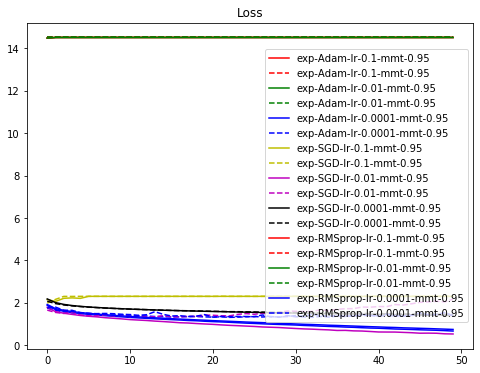

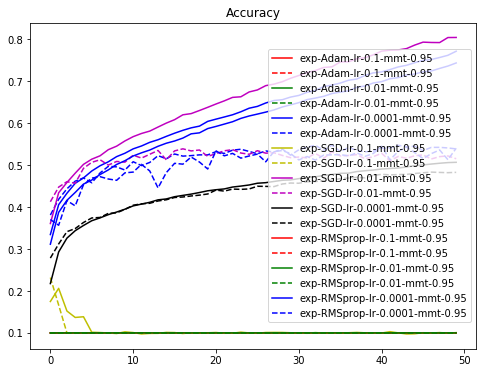

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","r", "g", "b" ]
#color_bar =['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()